# Visualization of bird sound files

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from pydub import AudioSegment
from scipy.io import wavfile

In [2]:
# custom matplotlib style
usetex = True
fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize + 2,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.style.use('ggplot')
plt.rcParams.update(params)

### Conversion: MP3 to WAV

Here, we take all the MP3 bird sounds inside the "ALL BIRDS" folder, and convert them into WAV files. 

We have to do this because WAV is the most supported format to do sound processing.

<div class='alert alert-warning'>
This step will take some minutes. 
<div>

In [3]:
# Read the ALL BIRDS folder
folder_path = 'ALL BIRDS'
files = os.listdir(folder_path)

# Create folder for the WAV files
if not os.path.exists('all_birds_wav'):
        os.makedirs('all_birds_wav')
        
# Convert all sounds
for file in files:
    sound_id = file.split('-')[-1].split('.')[0]
    sound = AudioSegment.from_mp3(os.path.join(folder_path, file))
    output_path = os.path.join('all_birds_wav', sound_id + '.wav')
    sound.export(output_path, format='wav')

In [4]:
# Read the Test Birds from Kasios
folder_path = 'Test Birds from Kasios'
files = os.listdir(folder_path)

# Create folder for the WAV files
if not os.path.exists('test_birds_kasios'):
    os.makedirs('test_birds_kasios')

# Convert all sounds
for file in files:
    sound_id = file.split('.')[0]
    sound = AudioSegment.from_mp3(os.path.join(folder_path, file))
    output_path = os.path.join('test_birds_kasios', sound_id + '.wav')
    sound.export(output_path, format='wav')    

### Visualize some sound files as a signals

In [5]:
folder_path = 'all_birds_wav'
files = os.listdir(folder_path)

sounds = []
for i in range(1, 9):    
    # Read WAV file
    f = os.path.join(folder_path, files[i])
    rate, data = wavfile.read(f)
    sounds.append(data)

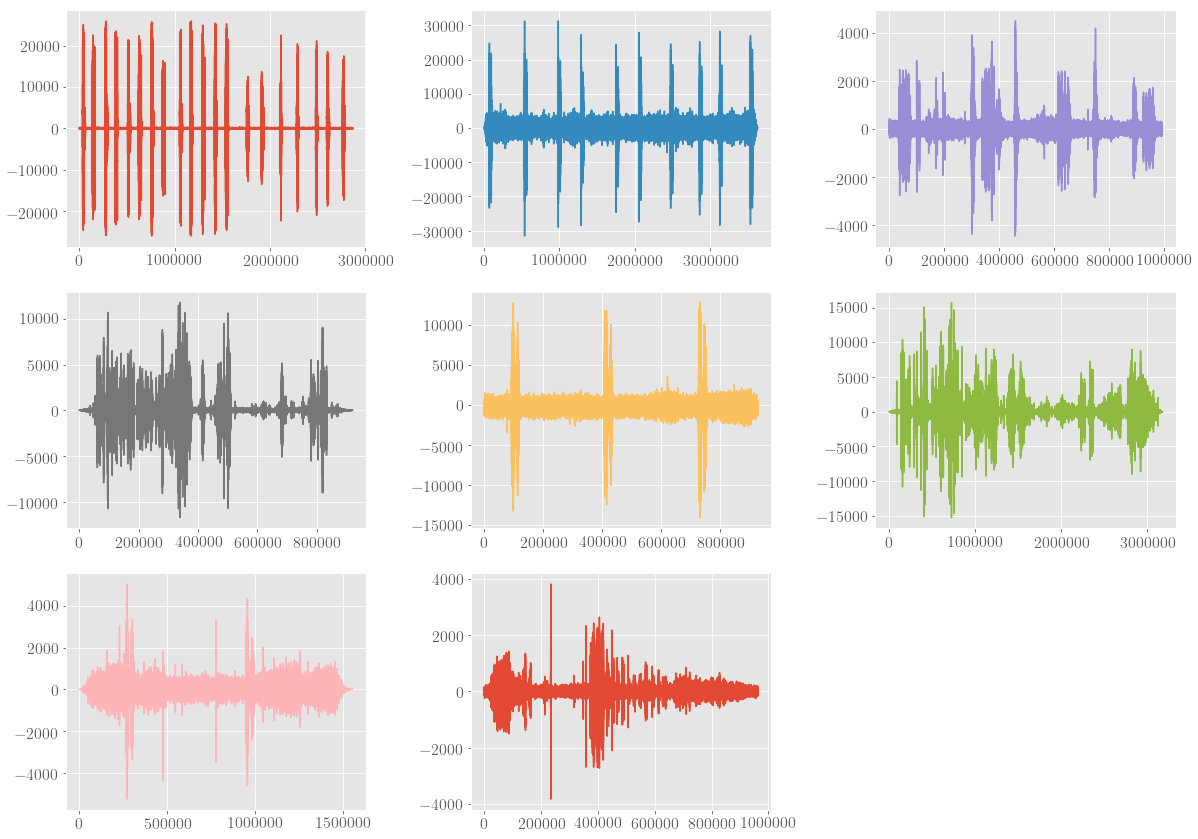

In [6]:
# visualize the signals
fig = plt.figure(figsize=(17,12))
for idx, sound in enumerate(sounds):
    ax = fig.add_subplot(3, 3, idx+1)
    ax.plot(sound, c="C{}".format(idx))
    
plt.tight_layout()
plt.show()

## Analysing birds sounds

**Aim**: Analyse the Kasios birds tests records and verify from which species each record belongs.

### 1) Visually

In [7]:
# Get a Rose-Crested-Blue-Pipit sample sound (n°160293)
folder_path = 'all_birds_wav'
files = os.listdir(folder_path)

sounds = []
f = os.path.join(folder_path, "162563.wav")
rate, data = wavfile.read(f)
sounds.append(data[:500000])

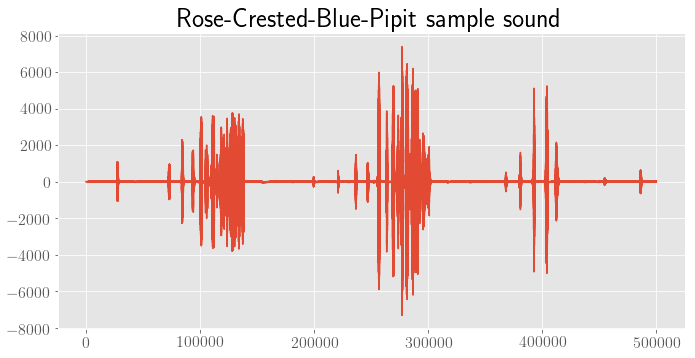

In [8]:
# visualize the signal
fig = plt.figure(figsize=(10,5))
plt.plot(sounds[0], c="C{}".format(0))
plt.tight_layout()
plt.title("Rose-Crested-Blue-Pipit sample sound")
plt.show()

In [9]:
# Get all tests sounds of Kasios
folder_path = 'test_birds_kasios'
files = os.listdir(folder_path)

for file in files:
    f = os.path.join(folder_path, file)
    rate, data = wavfile.read(f)
    sounds.append(data[:500000])

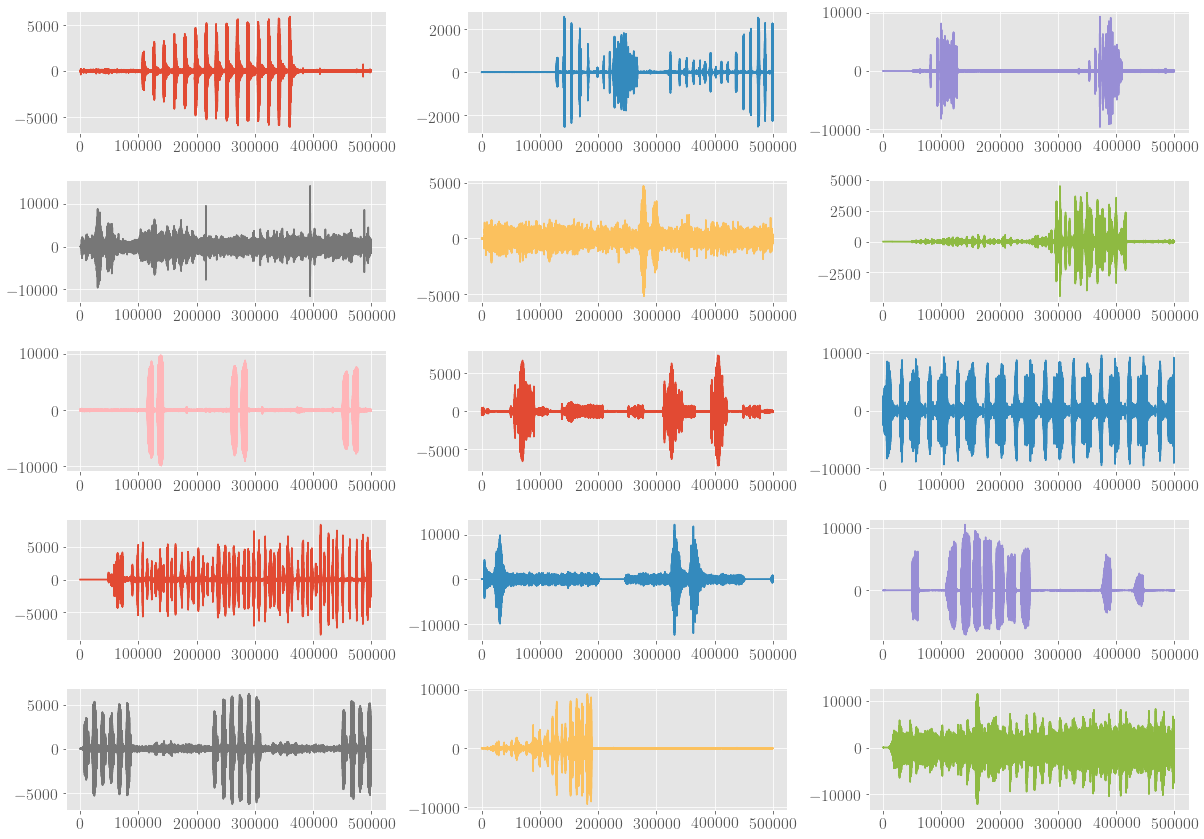

In [10]:
# visualize the signals
fig = plt.figure(figsize=(17,12))
for idx, sound in enumerate(sounds[1:]):
    ax = fig.add_subplot(5, 3, idx+1)
    ax.plot(sound, c="C{}".format(idx%9))
    
plt.tight_layout()
plt.show()

<div class='alert alert-info'>
We can remark that most of the test records from Kasios does not seem to be from the Rose-Crested-Blue-Pipit species. The second record may belong to a Rose-Crested-Blue-Pipit. We cannot be sure of the comparison. Therefore, we should do feature extraction.
<div>  

We may use some visual features in order to discriminate birds sounds such as:

- The minimum and maximum amplitudes.
- The distance between each call.

### 2) Using Machine Learning

From literature, we have found several methods to classify sounds depending on the bird species:

- Logistic Regression
- k Nearest Neighbour (kNN) classifier with histogram-based features
- Support Vector Machines (SVM) with time-summarisation features
- Random Forest

#### Create Dataframes

In [11]:
import pandas as pd

In [12]:
df_all_test = pd.read_csv('AllBirdsv4.csv')
#df_all_test = df_all.sample(frac=0.5)
#df_all_test = df_all.groupby('English_name').first()

# create a new column to tell wether it's a blue pipit or not : it will be our target for ML
type=[]
for i in range(len(df_all_test.index)):
    if str(df_all_test.loc[i,'English_name']) == 'Rose-crested Blue Pipit':
        type.append(1)
    else: 
        type.append(0)
        
df_all_test['Type']=type
df_all_show = df_all_test.groupby('English_name').head(20)
print(df_all_show)

      File ID             English_name Vocalization_type   Quality    Time  \
0      402254  Rose-crested Blue Pipit              call  no score   13:30   
1      406171  Rose-crested Blue Pipit              call         A    7:48   
2      405901  Rose-crested Blue Pipit              call         A   12:00   
3      405548  Rose-crested Blue Pipit              song         A   11:00   
4      401782  Rose-crested Blue Pipit              song         A    6:00   
5      401720  Rose-crested Blue Pipit              call         A   13:00   
6      401719  Rose-crested Blue Pipit              call         A   13:00   
7      387404  Rose-crested Blue Pipit              call         A   10:00   
8      377874  Rose-crested Blue Pipit              song         A    7:43   
9      368493  Rose-crested Blue Pipit              call         A   12:47   
10     368492  Rose-crested Blue Pipit              call         A   12:45   
11     364567  Rose-crested Blue Pipit              song        

In [13]:
# Read all files and computation of 4 parameters
folder_path = 'all_birds_wav'
files = os.listdir(folder_path)

sounds_all = []
for file_id in df_all_show['File ID']:
    # Read WAV file
    f = os.path.join(folder_path, "%s.wav" % (file_id))
    rate, data = wavfile.read(f)
    sounds_all.append(data[:500000])

In [56]:
# All files dataframe
mean_all = []
std_all = []
min_all = []
max_all = []

for sound in sounds_all:
    mean_all.append(np.mean(sound))
    std_all.append(np.std(sound))
    min_all.append(np.min(sound))
    max_all.append(np.max(sound))

df_all_show = df_all_show.assign(mean=mean_all, std=std_all, min=min_all, max=max_all)

print(df_all_show)

      File ID             English_name Vocalization_type   Quality    Time  \
0      402254  Rose-crested Blue Pipit              call  no score   13:30   
1      406171  Rose-crested Blue Pipit              call         A    7:48   
2      405901  Rose-crested Blue Pipit              call         A   12:00   
3      405548  Rose-crested Blue Pipit              song         A   11:00   
4      401782  Rose-crested Blue Pipit              song         A    6:00   
5      401720  Rose-crested Blue Pipit              call         A   13:00   
6      401719  Rose-crested Blue Pipit              call         A   13:00   
7      387404  Rose-crested Blue Pipit              call         A   10:00   
8      377874  Rose-crested Blue Pipit              song         A    7:43   
9      368493  Rose-crested Blue Pipit              call         A   12:47   
10     368492  Rose-crested Blue Pipit              call         A   12:45   
11     364567  Rose-crested Blue Pipit              song        

In [57]:
# Test records dataframe
df_test = pd.read_csv('Test Birds Location.csv')
#identity of the bird : english_name=[]
mean_test = []
std_test = []
min_test = []
max_test = []

for sound in sounds[1:]:
    mean_test.append(np.mean(sound))
    std_test.append(np.std(sound))
    min_test.append(np.min(sound))
    max_test.append(np.max(sound))

df_test['mean'] = mean_test
df_test['std'] = std_test
df_test['min'] = min_test
df_test['max'] = max_test

df_test = df_test.drop(columns=['ID'])

print(df_test)

      X    Y      mean          std    min    max
0   140  119 -1.567945   823.384694  -6129   5959
1    63  153  0.152346   226.241594  -2556   2592
2    70  136 -0.039621   610.004228  -9630   9350
3    78  150 -0.156732   957.414622 -11614  14137
4    60   90 -0.275236   535.063646  -5181   4710
5   126  103 -0.081314   374.105573  -4434   4515
6    71  121 -0.005854  1699.399254  -9872   9771
7    78   62 -0.108281   806.740225  -7125   7369
8    61  145  0.164347  2108.896946  -9593   9676
9    45   39 -1.835680  1041.399027  -8412   8355
10  132  106  0.049956   877.145881 -12501  12259
11   61   20  0.177216   841.454897  -7203  10620
12   35  160  0.052849  1240.569432  -6342   6248
13   40  125  0.175746   720.733950  -9492   9260
14  110  121 -0.056442  1549.638322 -12258  11579


In [58]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [77]:
neigh = KNeighborsClassifier(n_neighbors=19)

X_sample = df_all_show.drop(columns=['Quality', 'English_name', 'Vocalization_type', 'Time', 'Date', 'File ID', 'Type'])
X_sample["Y"] = X_sample["Y"].map(lambda y: y.replace("?",""))
X_sample['Y'] = X_sample['Y'].astype(float)

X = []

y = list(df_all_show["Type"])

for row in X_sample.iterrows():
    index, data = row
    X.append(data.tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=2,
           weights='uniform')

In [78]:
accuracy = neigh.score(X_test, y_test)
print("Accuracy: %s" % accuracy)

Accuracy: 0.9210526315789473


In [81]:
X_kasios = []

for row in df_test.iterrows():
    index, data = row
    X_kasios.append(data.tolist())

#### Predicting on Kasios sounds

In [82]:
prediction = neigh.predict(X_kasios)
print(prediction)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
